In [1]:
import sys 
sys.path.append("..") 
from train import *
from utils.score import cal_all_score
from dataloader import Dataload
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
matplotlib.use('TkAgg')
%matplotlib inline
import datetime
from utils.score_numpy import *

ModuleNotFoundError: No module named 'util'

In [2]:
batch_size = 10

In [3]:
parameter_path_dict = {
   41:r"H:\parameter_FPN\FL_GTU_jg/best.pkl",
}

In [4]:

# parameter_path_dict = {
#     911:r"H:/parameter_FPN/with_edge/model_2023_06_24_16_05_03_300444.pkl",
#     91:r"H:/parameter_FPN/3_6/model_2023_06_26_13_48_34_700476.pkl",
#     92:r"H:/parameter_FPN/FL_DETR_train/best.pkl",
#     921:r"H:/parameter_FPN/FL_DETR/model_2023_07_04_19_06_08_250032.pkl",
#     922:r"H:/parameter_FPN/FL_DETR_2/model_2023_07_04_20_52_02_588340.pkl",
#     923:r"H:/parameter_FPN/FL_DETR_reverse/model_2023_07_04_19_29_48_584903.pkl",
# }
parameter_path = parameter_path_dict[41]
batch_size = 10
method_dict = {
    0: "Unet",
    1: "RESUNet",
    2: 'RU',
    4:"GTU",
    41:"FL_GTU",
    5: "FL",
    8: "FL tiny",
    9: "FL FPN",
    91: "FL FPN 4 8",
    911: "FL FPN 911",
    92:"DETR",
    921:"FL_DETR B",
    922:"FL_DETR_2",
    923:"FL_DETR_reverse",
}

In [5]:
trainer = Train(
        1, (224),
        name = "FL_GPU_ja",
        method_type = 41,
        is_show = False,
        batch_size = batch_size,
        device_ = "cpu",
)

[3, 128, 256, 512, 1024]
[3, 128, 256, 512]
build FPN_GTU model
start paramete k:0.5, pre:0.5, p:0.5


In [6]:
trainer.load_parameter( parameter_path )

In [56]:
all_dataloader = Dataload( r'H:\DATASET\data/', (640,320), need_gray = False, data_aug = 1) # (320,640)
save_path = './test/'
save_path = save_path + trainer.name
all_dataloader.create_dir(save_path )
save_path = save_path + "/infers/"
print("验证集合大小: {} ".format( len( all_dataloader )))
all_dataloader.create_dir(save_path )
print( "save path:" , save_path)
print( "load parameter path:" , save_path)

H:\DATASET\data//image/ 88 H:\DATASET\data//mask/ 88
total: 88
验证集合大小: 88 
save path: ./test/FL_GPU_ja/infers/
load parameter path: ./test/FL_GPU_ja/infers/


In [73]:
def show_batch( origin, gt, generate, edge, save_path, file_name):
    #     origin = origin.detach().cpu().permute(1, 2, 0).numpy()   
    #     gt = gt.detach().cpu().permute(1, 2, 0).numpy()
    #     generate = generate.detach().cpu().permute(1, 2, 0).numpy()
    #     edge = generate.detach().cpu().permute(1, 2, 0).numpy()
    
    #     iou_score = mean_iou_np(gt, generate)
    #     dice_score = mean_dice_np(gt, generate)
    #     pr_score = positive_recall(gt, generate)
    #     nr_score = negative_recall(gt, generate)
    images = [origin, gt, generate, edge]
    titles = ['input', 'gt', 'generated', "edge"]
    # score = [["iou", iou_score] ,[ "dice", dice_score] ,[ "pr", pr_score] ,[ "nr", nr_score]]
    fig, ax = plt.subplots(1, 4, figsize=(20,15))
    for idx,img in enumerate(images):
        if idx == 0:
            imgan = images[0]
        else:
            imgan = img
        # print(idx, imgan.shape)
        # print( np.min(imgan) )
        imgan = np.array((imgan - np.min(imgan))/(np.max(imgan) - np.min(imgan)) * 255, dtype = np.uint8)
        imgan = cv2.cvtColor(imgan, cv2.COLOR_RGB2BGR)
        
        ax[idx].imshow(imgan)
        ax[idx].axis("off")
        
    for idx, title in enumerate(titles):    
        ax[idx].set_title('{}'.format(title), fontsize=12)
        #ax[idx].set_xlabel("{} {:.4f}".format(score[idx][0], score[idx][1]))
    
    f = plt.gcf()  #获取当前图像
    f.savefig(save_path + '/{}.png'.format(file_name))

    f.clear()  #释放
    
    

In [74]:
trainer.model = trainer.model.cuda()

In [75]:
save_path, file_name

('./test/FL_GPU_ja/infers/', '1.png')

FileNotFoundError: [Errno 2] No such file or directory: './test/FL_GPU_ja/infers//1.png'

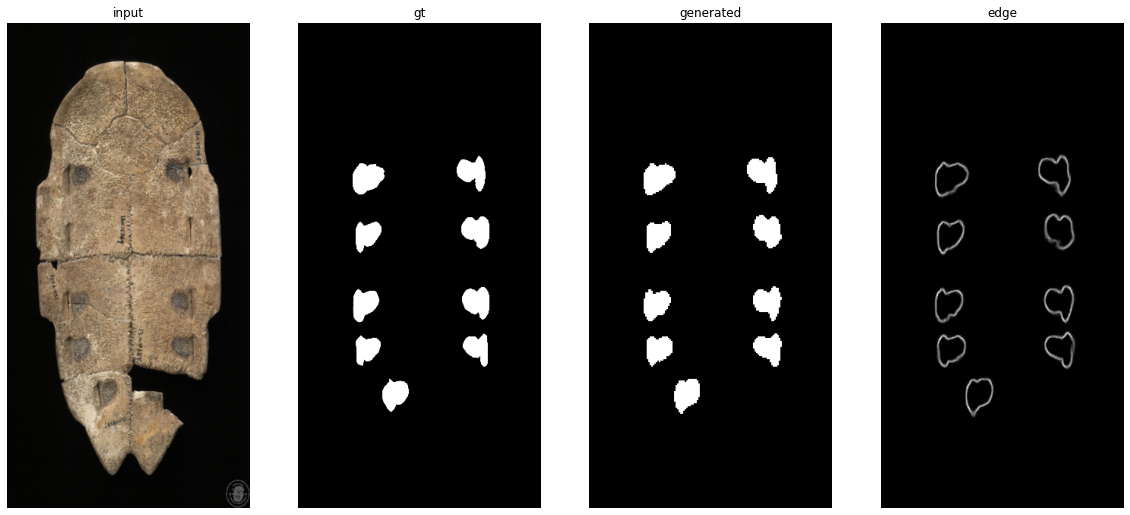

In [83]:
total = len(all_dataloader)
score_list = []
index = 0
start_time = datetime.datetime.now() 
for image_dict in all_dataloader.photo_set:
    image_path = image_dict["image"]
    image_gt_path = image_dict["gt"]
                               
    image = all_dataloader.read_image_data(image_path)
  
    gt = all_dataloader.read_image_data(image_gt_path, True)
    gt = cv2.resize(gt, (320,640))            
    batch_image = all_dataloader.datagen_val( image )
    batch_gt = all_dataloader.datagen_val( gt )
    file_name = image_path.split("/")[-1]

    batch_image = batch_image.cuda()#cpu()
    out = trainer.predict_batch(batch_image.unsqueeze(0))
    mask = out["mask"].squeeze().cpu().numpy()
    edge = out["edge"].squeeze().cpu().numpy()
    # mask[ edge != 0 ] = edge
    image = batch_image.squeeze().permute(1,2,0).cpu().numpy()
                   
    mask[ mask >= 0.5 ] = 1
    mask[ mask < 0.5 ] = 0
    imgan = np.array(mask * 255, dtype = np.uint8)
    imgan = cv2.cvtColor(imgan, cv2.COLOR_RGB2BGR)
    imGray = cv2.cvtColor(imgan, cv2.COLOR_BGR2GRAY)
                               
    imgan_ = np.array(edge * 255, dtype = np.uint8)
    imgan_ = cv2.cvtColor(imgan_, cv2.COLOR_RGB2BGR)
    imGray_edge = cv2.cvtColor(imgan_, cv2.COLOR_BGR2GRAY)
                               
    show_batch(image, gt, imGray, imGray_edge, save_path, file_name[:-4])
    if index % 100 == 0:
        print("ETA: ", index," / " ,np.round(( total - index )*(datetime.datetime.now() - start_time).seconds / 60, 3) , end='\r')
        start_time = datetime.datetime.now() 
    index += 1
print("done  500  /  0 ")

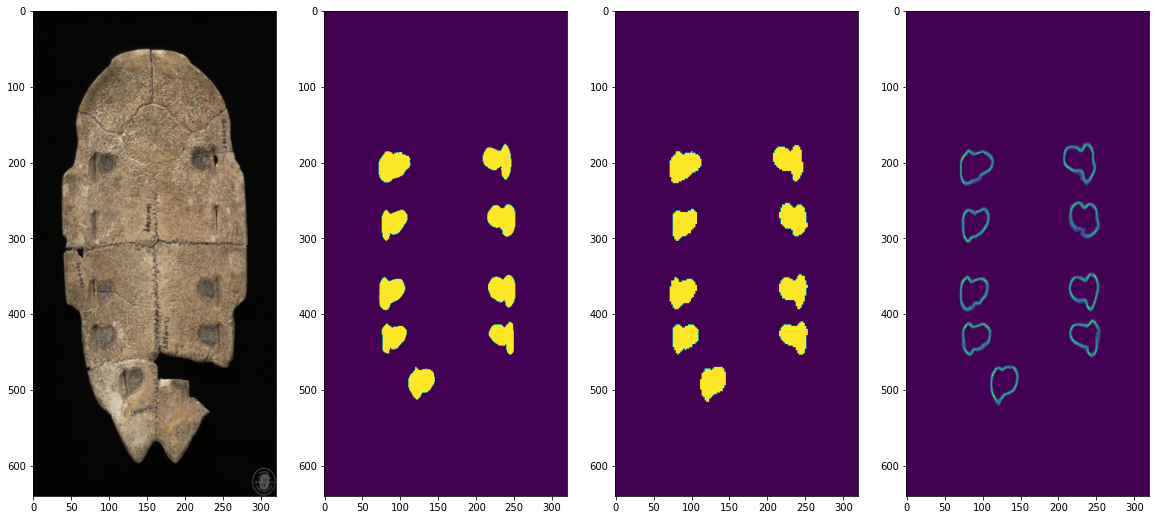

In [87]:
plt.figure(figsize=(20,15))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplot(141)
plt.imshow( image )
plt.subplot(142)
plt.imshow( gt )
plt.subplot(143)
plt.imshow( imGray )
plt.subplot(144)
plt.imshow( imGray_edge )
plt.show()

In [100]:

imGray_edge = np.array((imGray_edge - np.min(imGray_edge))/(np.max(imGray_edge) - np.min(imGray_edge)) * 255, dtype = np.uint8)

In [107]:
add = imGray_edge  + imGray
add = np.array((add - np.min(add))/(np.max(add) - np.min(add)) * 255, dtype = np.uint8)

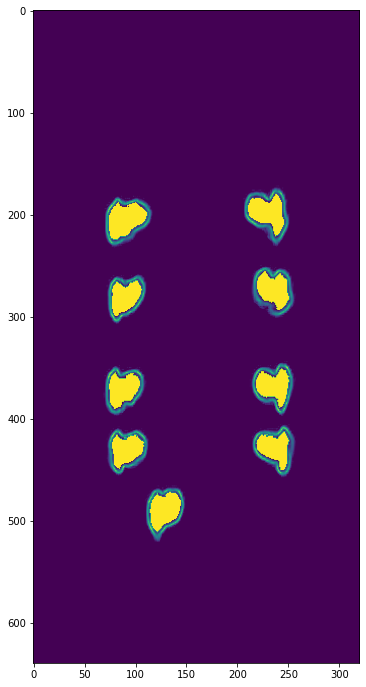

In [108]:
plt.figure(figsize=(12,12))
plt.imshow( add ) 
plt.show()

In [119]:
kernel=cv2.getStructuringElement(shape=cv2.MORPH_RECT,ksize=(3,3))
img=cv2.morphologyEx(src=add,op=cv2.MORPH_CLOSE,kernel=kernel,iterations=3)

In [120]:
img[img != 0] = 255

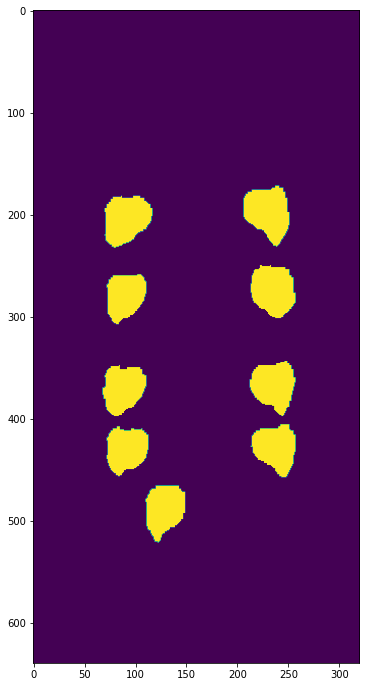

In [121]:
plt.figure(figsize=(12,12))
plt.imshow( img ) 
plt.show()